<a href="https://colab.research.google.com/github/saipklvs/LearnDL/blob/main/Torch_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MNIST Data Setup

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


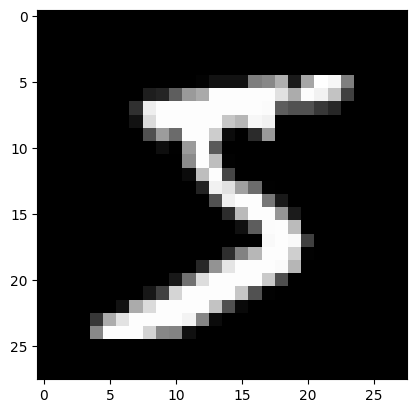

In [5]:
from matplotlib import pyplot as plt
import numpy as np 

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## NN from scratch with out using torch.nn

In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [8]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

In [9]:
bs = 64 ## Batch size

xb    = x_train[0:64]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.4364, -2.0622, -2.5498, -2.4536, -2.3807, -2.5694, -2.4874, -2.1485,
        -1.7382, -2.5696], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll


In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3648, grad_fn=<NegBackward0>)


In [12]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1094)


## Using torch.nn method now

In [13]:
import torch.nn.functional as F
loss_func = F.cross_entropy
def model(xb):
  return xb @ weights + bias
print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(2.3648, grad_fn=<NllLossBackward0>) tensor(0.1094)


In [18]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.weights = nn.Parameter(torch.randn(784, 10)/ math.sqrt(784))
      self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias

model = Mnist_Logistic()

In [15]:
print(loss_func(model(xb), yb))

tensor(2.2648, grad_fn=<NllLossBackward0>)


In [20]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [21]:
print(loss_func(model(xb), yb))

tensor(0.2239, grad_fn=<NllLossBackward0>)


### Refactoring using nn.Linear

In [22]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [23]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3026, grad_fn=<NllLossBackward0>)


In [24]:
## optim method from pytorch
from torch import optim

def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
  for i in range((n-1)// bs+1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2907, grad_fn=<NllLossBackward0>)
tensor(0.0806, grad_fn=<NllLossBackward0>)


### Refactor using the Dataset

In [25]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()
for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    xb, yb = train_ds[i * bs: i * bs + bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward0>)


### Refactor using DataLoader

In [26]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [27]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward0>)


### Adding the validation code

In [28]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [29]:
model, opt = get_model()

for epoch in range(epochs):
  model.train() ## Other layers use these things so need to be careful
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))
  

0 tensor(0.3043)
1 tensor(0.3097)


In [30]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

In [35]:
import numpy as np 

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

    model.eval()
    with torch.no_grad():
      losses, nums = zip(
          *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    print(np.multiply(losses, nums))
    print(np.sum(nums))
    print(epoch, val_loss)


In [36]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [37]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

[42.69467163 58.86672592 60.11135101 59.16778946 65.47225952 37.06748581
 31.92751503 22.07134056 27.47363281 46.72779083 38.57035446 32.78249741
 30.95267296 43.42460632 26.39731026 52.53293991 69.19068146 48.90090561
 48.20304489 25.6619606  40.51237106 58.82416153 76.88926697 63.44594193
 40.27467346 32.93897629 11.4796772  61.22492981 40.78321838 34.45820618
 52.77666092 60.29216385 34.45368195 26.32693672 40.14183426 53.40417862
 25.80377769 41.36223221 71.55936432 36.26722336 33.93166351 46.50324631
 27.29217148 37.12293243 45.79296112 32.58626556 31.98967934 22.87147141
 35.71164322 40.52845383 48.82256699 40.67875671 24.04631233 25.16799927
 35.73348999 31.96892929 26.60120392 29.52937508 37.81183624 41.93375397
 44.4004097  25.75593376 29.59951019 29.81352615 17.18136978 19.55633736
 23.25042343 24.50388145 26.91110229 25.45763969 12.304389   13.10648155
 41.23868179 61.90419769 10.74346733 55.88201141 42.60552216 32.70718384
  0.9135232 ]
10000
0 0.30058773169517516
[39.34494

### Switch to CNN

In [41]:
class Mnist_CNN(nn.Module):
  def __init__(self) -> None:
     super().__init__()
     self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
     self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
     self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    return xb.view(-1, xb.size(1))

lr = 0.1

In [42]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

[44.66065216 64.04773712 67.23487091 62.9962616  65.11781311 49.96343613
 51.37452698 37.81975174 26.30703163 51.24075699 38.29655075 31.68341637
 32.31424332 24.17639923 37.48273087 45.00035095 76.29294586 38.52676773
 27.335989   18.29151154 36.97792816 49.08999634 74.49150085 46.34023285
 40.45558167 44.51451492 24.4113884  45.66981506 33.47930145 31.11265182
 44.4462204  76.6113739  37.56798935 31.77242851 50.62171936 42.22915649
 23.69790077 35.90010834 76.83727264 47.86358261 32.93867111 40.37922668
 36.9789772  45.38218307 44.50918198 35.28160477 36.52193832 21.81497574
 43.81007385 47.19586563 55.02393341 34.18526077 29.38562965 32.87384033
 34.38581467 33.03677368 35.73688889 47.81780243 34.8270874  50.88381577
 56.10602951 36.29177475 40.20756912 28.65758705 15.66879749 48.39633179
 40.14343643 31.06231308 20.48589897 25.56808662 12.07241154 17.67040253
 61.67296219 88.59532166 35.60690308 50.49039078 47.56288147 33.20644379
  3.89865446]
10000
0 0.3250588149547577
[38.378654